# Hello Wolt!

In [1]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pickle
from datetime import datetime

Using TensorFlow backend.


First, we start with importing all the necessary libraries

In [2]:
DIRECTORY = './input/'
LEARN = False

locations = pd.read_csv(DIRECTORY + 'locations.csv')
pickup_times = pd.read_csv(DIRECTORY + 'pickup_times.csv')
pickup_times['date'] = pd.to_datetime(pickup_times['iso_8601_timestamp'])
pickup_times = pickup_times.drop(['iso_8601_timestamp'], axis=1)

Next we load `locations` and `pickup_times` datasets.

For `pickup_times` I parse the time into Pandas Timestamp, which is more comfortoble to work with.

In [3]:
def onehot(inpt, base):
    out = np.zeros((inpt.shape[0], base))
    i = 0
    for location_id in np.nditer(inpt):
        out[i, location_id-1] = 1
        i += 1
    return out.astype(int)

In [4]:
def prepare_date(df_date):
    weekdays_one_hot_df = pd.DataFrame(onehot(df_date.map(lambda x: x.dayofweek).values, 7))
    time_flat_series = df_date.map(lambda a: (a.hour-10)/10 + a.minute/600)
    
    weekdays_one_hot_df['time'] = time_flat_series
    return weekdays_one_hot_df

In the `prepare_date` function we import `dates` column from `pickup_times` and:
 1. Parse weekdays and create one-hot encoded dataframe like `[1,0,0,0,0,0,0]` where `1` on 0th place represent monday. [One-how encoding](https://en.wikipedia.org/wiki/One-hot)
 2. We encode the pickup time into simple value in range [0, 1]. Knowing that delivery day in Wolt is 10 hours we can simply take an hour (staring with 0 to 10, where 0 is 10AM and 10 is 8PM) and divide it by 10 and add minute divided by 600 (so that new minute value will be in range[0, 0.1] and nicely represent one hour).
 3. Return the result as merged series.

In [5]:
def prepare_data(df, sort=False):
    if sort:
        df = df.sort_values(by=['date']).reset_index().drop(['index'], axis = 1)
    dates = prepare_date(df['date'])
    places_dummies = pd.DataFrame(onehot(df['location_id'].values, 85)) # 85 locations
    
    return pd.concat([dates, places_dummies], axis=1).values, (df['pickup_time']/90).values if 'pickup_time' in df.columns else False#, dates, places_dummies  

X, y = prepare_data(pickup_times)

Atfer that, we merge dates, which came from the previous step, with places ids, which are also One-Hot encoded.
I implemented simple OneHot encoding function with base 85 in place of simply using `pandas.get_dummies` to be able to encode sequences of small lengths.

In [6]:
if LEARN:
    model = Sequential()

    model.add(Dense(124, kernel_initializer='normal', activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer='normal', activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_initializer='normal', activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer='normal', activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(124, kernel_initializer='normal', activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

    history = model.fit(X, y, epochs=200, validation_split = 0.2, batch_size=128, verbose=1).history
    model.save(DIRECTORY + "wolt_model.h5")
    with open(DIRECTORY + 'wolt_learning_history.pkl','wb') as f:
        pickle.dump(history, f)
else:
    model = load_model(DIRECTORY + 'wolt_model.h5')
    with open(DIRECTORY + 'wolt_learning_history.pkl','rb') as f:
        history = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


**If you want to teach the model on your computer set LEARN = True, but be prepared that it takes long time**
Here we define a model with 11 layers: 5 hidden layers with 124-512 scaled exponential linear units, 5 dropout layers, and one output sigmoid layer.

Then we teach the model with 200 epochs.

Of course, you don't really want to learn the model yourself, so I import a prepared one.

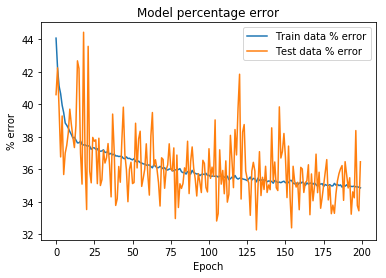

In [7]:
plt.plot(history['mean_absolute_percentage_error'])
plt.plot(history['val_mean_absolute_percentage_error'])
plt.title('Model percentage error')
plt.ylabel('% error')
plt.xlabel('Epoch')
plt.legend(['Train data % error', 'Test data % error'], loc='upper right')
plt.show()

The plot above shows how the model lowers the error during the learning process.

## Results

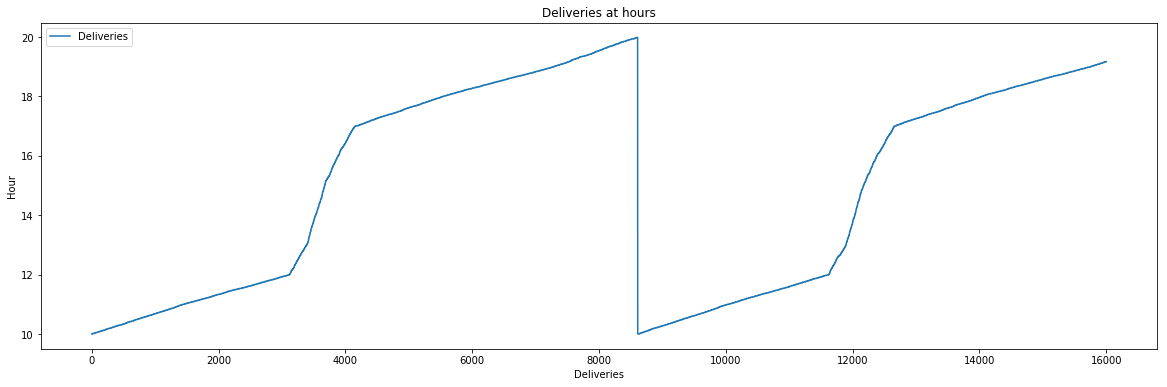

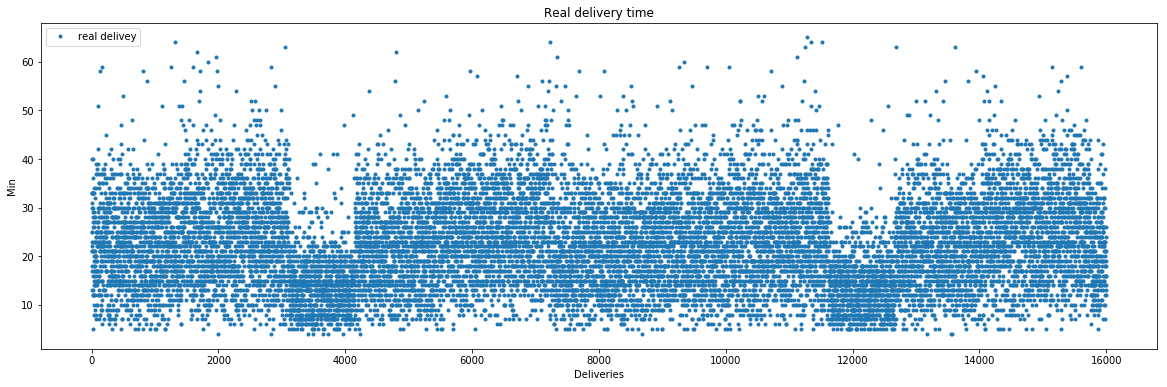

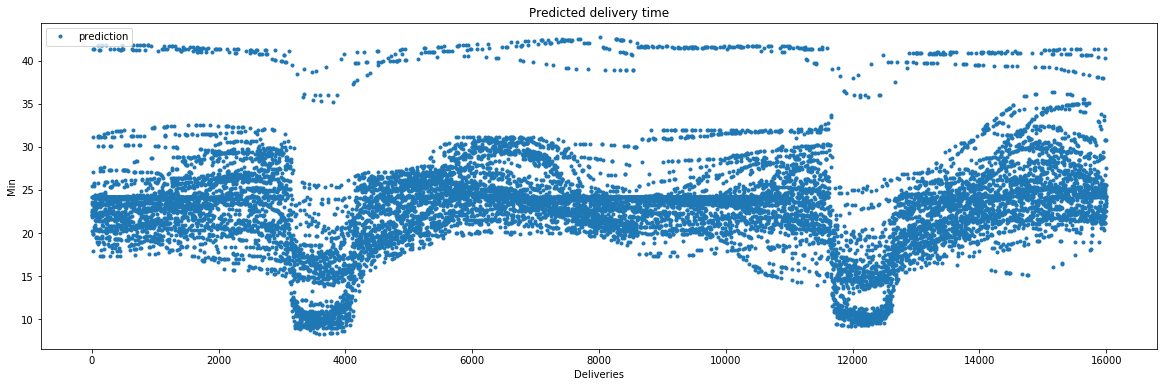

In [8]:
S=0
E=16000

X, y = prepare_data(pickup_times, sort=True)

plt.figure(figsize=(20,6))
plt.plot(X[S:E,7] * 10 + 10)
plt.title('Deliveries at hours')
plt.ylabel('Hour')
plt.xlabel('Deliveries')
plt.legend(['Deliveries'], loc='upper left')
plt.show()

plt.figure(figsize=(20,6))
plt.plot(y[S:E]*90, '.')
plt.title('Real delivery time')
plt.ylabel('Min')
plt.xlabel('Deliveries')
plt.legend(['real delivey'], loc='upper left')
plt.show()

plt.figure(figsize=(20,6))
plt.plot(model.predict(X[S:E])*90, '.')
plt.title('Predicted delivery time')
plt.ylabel('Min')
plt.xlabel('Deliveries')
plt.legend(['prediction'], loc='upper left')
plt.show()

On the graphs above you can see the results of the training.

The first graph shows deliveries at particular moments of time. This graph is not intuitive in the begining, but I chose it to see the results of the learning from different angles.
The steeper is the slope the lower is the amount of deliveries. We can see that somewhere between ~3000 and ~4000 Deliveries the slope is super steep, and corresponds to timegap between 12 and 17 hours. So, aproximately 1000 deliveries was done in 5 hours in the afternoon. 
On the contrary, in the morning and evening we see the most amount of deliveries: 3000 in 2 hours between 10 and 12, almost 5000 in 3 hours between 17 and 20.
Then you see the fall around 9000th delivery - that is the start of the new day.

The second graph represents the real delivery times right along the first graph. Same scale for deliveries.
You can see that the delivery time drops dramatically during this "Mid-day emptiness". Probably, it depends on the amount of deliveries and trafic, which starts from 17.

The third graph represents the predicted delivery time.

# Conclusion

With only given dataset we can predict how long the pickup time will be with at ~35% error. The error will decrease with extra data input. It can be past delivery data, weather conditions, traffic in the city, and other factors.

